# Sentiment Analysis for Consumer Reviews of Amazon Products

In [1]:
# modules we'll use

import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.utils import resample
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# 1- Geting the Dataset

In [2]:
data = pd.read_csv('reviews.csv')

/home/karim/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 2- Data Preprocessing

In [3]:
data = data[['reviews.text', 'reviews.rating']]

In [4]:
data.rename(columns={'reviews.text':'text', 'reviews.rating':'rating'}, inplace=True)

In [5]:
data.head()

,text,rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [6]:
data.isnull().sum()

text       1
rating    33
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
data.isnull().sum()

text      0
rating    0
dtype: int64

In [9]:
data.rating.value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: rating, dtype: int64

In [10]:
data.shape

(34626, 2)

In [11]:
data.rating = data.rating.map({1:0, 2:0, 3:0, 4:1, 5:1})

In [12]:
data.rating.value_counts()

1    32315
0     2311
Name: rating, dtype: int64

**Convert all text to lower case**

In [13]:
data.text = data['text'].str.lower()

**Tokenization and Lemmatization**

In [14]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')

In [15]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [16]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]

In [17]:
data.text = data.text.apply(lemmatize_text)

In [18]:
data.head()

,text,rating
0,"[this, product, so, far, ha, not, disappointed...",1
1,"[great, for, beginner, or, experienced, person...",1
2,"[inexpensive, tablet, for, him, to, use, and, ...",1
3,"[i, ve, had, my, fire, hd, two, week, now, and...",1
4,"[i, bought, this, for, my, grand, daughter, wh...",1


**Remove stop words**

In [19]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/karim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def remove_stops(row):
    return [w for w in row if not w in stop_words]

In [21]:
data.text = data.text.apply(remove_stops)

In [22]:
def rejoin_words(row):
    return (" ".join(row))

In [23]:
data.text = data.text.apply(rejoin_words)

In [24]:
data.head()

,text,rating
0,product far ha disappointed child love use lik...,1
1,great beginner experienced person bought gift ...,1
2,inexpensive tablet use learn step nabi wa thri...,1
3,fire hd two week love tablet great value prime...,1
4,bought grand daughter come visit set user ente...,1


# -------------------------------------------------------------------------------------------------------------

## Select a model and train it

In [25]:
def confusion_mat(predictions, labels):
    """
    predictor : Predictor object of model
    features: Input features to model
    label: Ground truth target values
    """

    accuracy = (predictions == labels).sum() / labels.shape[0]
    print(f'Accuracy: {accuracy}')
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average = 'binary')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')
    
    confusion_matrix = pd.crosstab(index=labels, columns=predictions, rownames=['Actual'], colnames=['Predicted']).astype(int)
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap="YlGnBu").set_title('Confusion Matrix') 

## Trying Count Vectorizer

In [26]:
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, max_features=10000)
features = vectorizer.fit_transform(data.text)

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(features, data['rating'], test_size=0.20, random_state=5, shuffle=True)

In [29]:
sm = SMOTE(random_state=5)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

In [30]:
Y_train.value_counts()

0    25865
1    25865
Name: rating, dtype: int64

## Naive Bayes

In [31]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [32]:
MNB_train_predictions = MNB.predict(X_train)

Accuracy: 0.871486564855983
Precision: 0.8566232416583157
Recall: 0.8923255364392035
F1_score: 0.8741099833358582


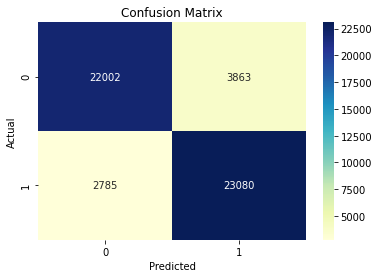

In [33]:
confusion_mat(MNB_train_predictions, Y_train)

In [34]:
MNB_test_predictions = MNB.predict(X_test)

Accuracy: 0.862258157666763
Precision: 0.9657627118644068
Recall: 0.8834108527131783
F1_score: 0.922753036437247


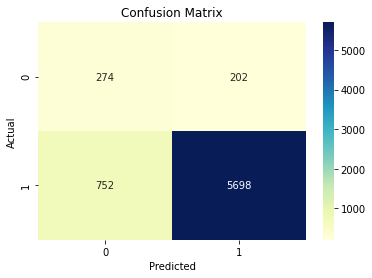

In [35]:
confusion_mat(MNB_test_predictions, Y_test)

## XGBoost Classifier

In [36]:
xgb= XGBClassifier()
xgb.fit(X_train, Y_train)

/home/karim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:14:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
xgb_train_predictions = xgb.predict(X_train)

Accuracy: 0.9719891745602165
Precision: 0.9488895425797912
Recall: 0.9977189251884786
F1_score: 0.9726918075422626


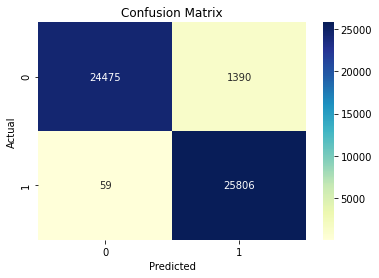

In [38]:
confusion_mat(xgb_train_predictions, Y_train)

In [39]:
xgb_test_predictions = xgb.predict(X_test)

Accuracy: 0.9357493502743286
Precision: 0.9417390025011034
Recall: 0.9924031007751938
F1_score: 0.9664074884879594


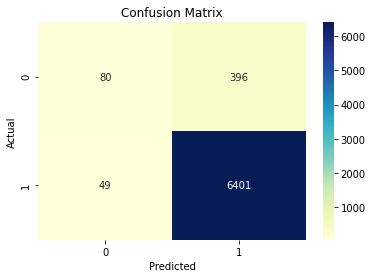

In [40]:
confusion_mat(xgb_test_predictions, Y_test)

# -------------------------------------------------------------------------------------------------------------

## Trying Term Frequencies Vectorizer

In [52]:
vectorizer2 = TfidfVectorizer(use_idf=False, tokenizer=tokenizer.tokenize)
features2 = vectorizer2.fit_transform(data.text)

In [53]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(features2, data['rating'], test_size=0.20, random_state=5, shuffle=True)

In [54]:
sm2 = SMOTE(random_state=5)
X_train2, Y_train2 = sm2.fit_resample(X_train2, Y_train2)

In [55]:
Y_train2.value_counts()

0    25865
1    25865
Name: rating, dtype: int64

## Naive Bayes

In [56]:
MNB2 = MultinomialNB()
MNB2.fit(X_train2, Y_train2)

MultinomialNB()

In [59]:
MNB2_train_predictions = MNB2.predict(X_train2)

Accuracy: 0.867137057800116
Precision: 0.8736523176202093
Recall: 0.8584187125459115
F1_score: 0.8659685251272451


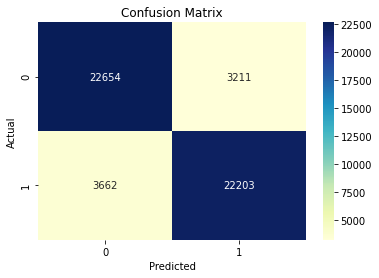

In [60]:
confusion_mat(MNB2_train_predictions, Y_train2)

In [61]:
MNB2_test_predictions = MNB2.predict(X_test2)

Accuracy: 0.8320820098180768
Precision: 0.9775971093044263
Recall: 0.8389147286821705
F1_score: 0.9029620358781811


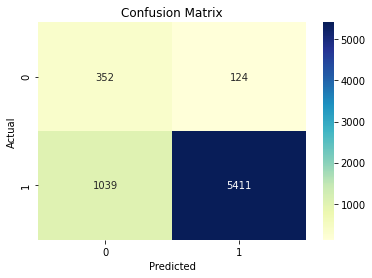

In [62]:
confusion_mat(MNB2_test_predictions, Y_test2)

## XGBoost Classifier

In [63]:
xgb2= XGBClassifier()
xgb2.fit(X_train2, Y_train2)

/home/karim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:30:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
xgb2_train_predictions = xgb2.predict(X_train2)

Accuracy: 0.9591726271022617
Precision: 0.941030116231572
Recall: 0.9797409626908951
F1_score: 0.9599954540288669


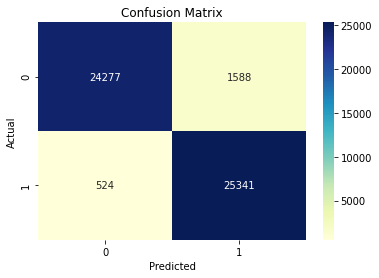

In [65]:
confusion_mat(xgb2_train_predictions, Y_train2)

In [66]:
xgb2_test_predictions = xgb2.predict(X_test2)

Accuracy: 0.9110597747617672
Precision: 0.9535136815920398
Recall: 0.9508527131782946
F1_score: 0.952181338301506


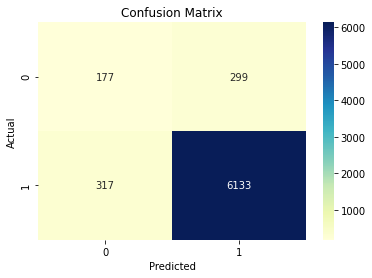

In [67]:
confusion_mat(xgb2_test_predictions, Y_test2)

# -------------------------------------------------------------------------------------------------------------

## Trying Term Freq. - Inverse Document Freq. Vectorizer

In [68]:
vectorizer3 = TfidfVectorizer(tokenizer=tokenizer.tokenize)
features3 = vectorizer3.fit_transform(data.text)

In [69]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(features3, data['rating'], test_size=0.20, random_state=5, shuffle=True)

In [70]:
sm3 = SMOTE(random_state=5)
X_train3, Y_train3 = sm3.fit_resample(X_train3, Y_train3)

In [71]:
Y_train3.value_counts()

0    25865
1    25865
Name: rating, dtype: int64

## Naive Bayes

In [72]:
MNB3 = MultinomialNB()
MNB3.fit(X_train3, Y_train3)

MultinomialNB()

In [73]:
MNB3_train_predictions = MNB3.predict(X_train3)

Accuracy: 0.8831239126232361
Precision: 0.891664361092447
Recall: 0.8722211482698627
F1_score: 0.8818355939491068


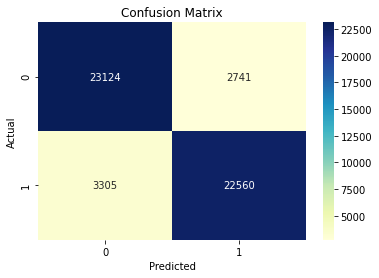

In [74]:
confusion_mat(MNB3_train_predictions, Y_train3)

In [75]:
MNB3_test_predictions = MNB3.predict(X_test3)

Accuracy: 0.8375685821542016
Precision: 0.9745143468187489
Recall: 0.8477519379844961
F1_score: 0.9067241522261836


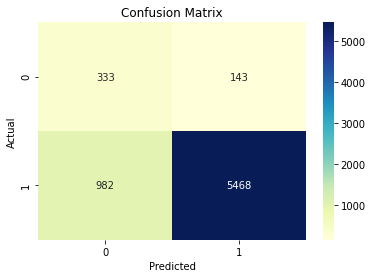

In [76]:
confusion_mat(MNB3_test_predictions, Y_test3)

## XGBoost Classifier

In [77]:
xgb3 = XGBClassifier()
xgb3.fit(X_train3, Y_train3)

/home/karim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:34:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
xgb3_train_predictions = xgb3.predict(X_train3)

Accuracy: 0.9536245892132225
Precision: 0.9355233853006681
Recall: 0.9744055673690315
F1_score: 0.9545686961461982


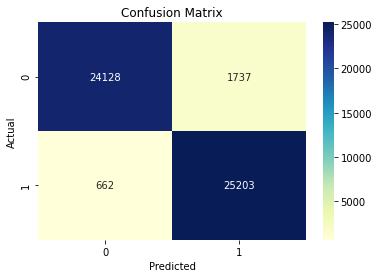

In [79]:
confusion_mat(xgb3_train_predictions, Y_train3)

In [80]:
xgb3_test_predictions = xgb3.predict(X_test3)

Accuracy: 0.9091827894888824
Precision: 0.9545525534905513
Recall: 0.9475968992248062
F1_score: 0.9510620088695246


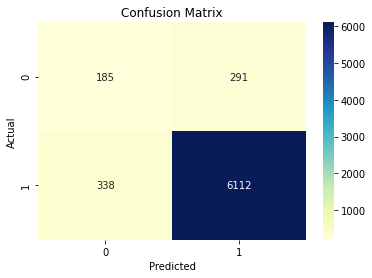

In [81]:
confusion_mat(xgb3_test_predictions, Y_test3)